In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

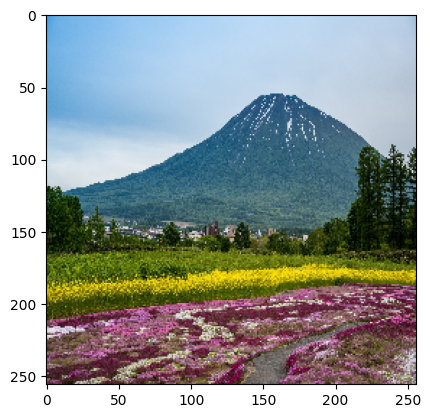

(3, 256, 256)

In [2]:
image = cv2.imread('/Users/akhildevarashetti/code/vision_lab/vision_lab/generation/diffusion/image.jpg')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.transpose(image, (2, 0, 1))
image = image.astype(np.float32) / 255.0
# image = image - 0.5

def imshow(image):
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()

imshow(image)
image.shape

# Forward Process

In the forward process,

- We define number of steps T.
-

In [27]:
T = 11

ts = np.arange(0, T)
extreme = 0.001
b = np.linspace(extreme, 1-extreme, T)
a = 1 - b
print(a)
print(b)
a_bar = np.cumprod(a)
assert len(ts) == len(a) == T

forward_chain = []
labels = []
errors = []
magnitudes = []
image_t = image.copy()
for t in ts:
    noise = np.random.randn(*image.shape).astype(np.float32)
    image_t_prev = image_t.copy()
    image_t_next = a[t] * image_t_prev + b[t] * noise
    image_t = image_t_next.copy()
    # label_t = 1/a[t] * (image_t_next - b[t] * noise)

    labels.append(noise)
    forward_chain.append(image_t.copy())
    magnitudes.append(np.mean(image_t))
    errors.append(np.mean((image - image_t) ** 2))

[0.999  0.8992 0.7994 0.6996 0.5998 0.5    0.4002 0.3004 0.2006 0.1008
 0.001 ]
[0.001  0.1008 0.2006 0.3004 0.4002 0.5    0.5998 0.6996 0.7994 0.8992
 0.999 ]


In [30]:
# Backward process
noisy_image = forward_chain[T-1]
for t in reversed(ts[1:]):  # T-1 to 1
    noise = labels[t]  # This comes from the model.
    # if t == T - 1:
    #     # impossible as it lost all image information.
    #     noisy_image = forward_chain[T-2]
    # else:
    noisy_image = 1/a[t] * (noisy_image - b[t] * noise)

    error = np.mean((forward_chain[t-1] - noisy_image) ** 2)
    print(f"{t}: {error}")
error = np.mean((image - noisy_image) ** 2)
print(f"denoised error: {error}")

10: 2.2077547828653288e-27
9: 2.1728532300987593e-25
8: 5.399687227139958e-24
7: 5.983685439581172e-23
6: 3.736066492024551e-22
5: 1.4944265901182243e-21
4: 4.153953782615233e-21
3: 8.487153534556696e-21
2: 1.3281091548206713e-20
1: 1.642559743025266e-20
denoised error: 1.335464630016999e-06


/var/folders/qz/8lxmcg3s6ls7rqr51bjgj4080000gp/T/ipykernel_78096/2865436034.py:14: RuntimeWarning: invalid value encountered in scalar divide
  image_t_prev = a_bar[t] / a[t] * image + (1 - a_bar[t] / a[t]) * noise1


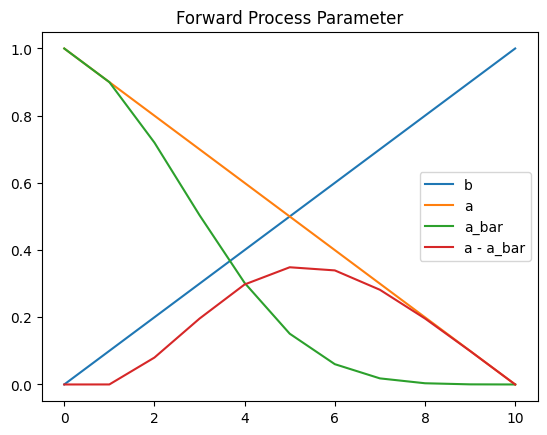

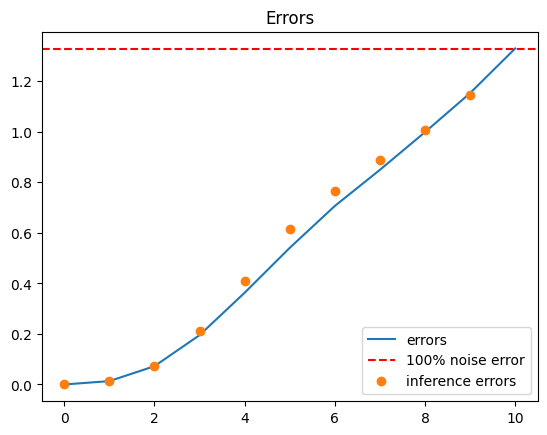

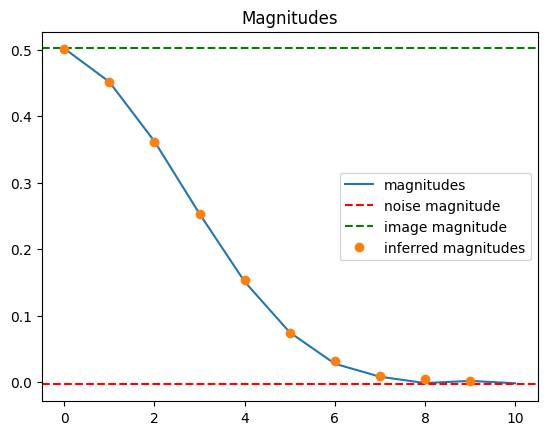

In [19]:
noise_reference = np.random.randn(*image.shape).astype(np.float32)
errors_reference = np.mean((image - noise_reference) ** 2)
magnitude_noise = np.mean(noise_reference)
magnitude_image = np.mean(image)

# Single step trick.
random_ts = ts  # np.random.randint(1, T, 5)
random_errors = []
random_magnitudes = []
for t in random_ts:
    noise1 = np.random.randn(*image.shape).astype(np.float32)
    noise2 = np.random.randn(*image.shape).astype(np.float32)
    # image_t_prev = a_bar[t-1] * image + (1 - a_bar[t-1]) * noise1
    image_t_prev = a_bar[t] / a[t] * image + (1 - a_bar[t] / a[t]) * noise1
    image_t = a[t] * image_t_prev + b[t] * noise2
    # image_t = a_bar[t] * image + (a[t] - a_bar[t]) * noise1 + (1 - a[t]) * noise2
    random_magnitudes.append(np.mean(image_t))
    random_errors.append(np.mean((image - image_t) ** 2))

plt.title("Forward Process Parameter")
plt.plot(ts, b, label='b')
plt.plot(ts, a, label='a')
plt.plot(ts, a_bar, label='a_bar')
plt.plot(ts, a - a_bar, label='a - a_bar')
plt.legend()
plt.show()

plt.title("Errors")
plt.plot(ts, errors, label='errors')
plt.axhline(errors_reference, color='r', linestyle='--', label='100% noise error')
plt.plot(random_ts, random_errors, 'o', label='inference errors')
plt.legend()
plt.show()

plt.title("Magnitudes")
plt.plot(ts, magnitudes, label='magnitudes')
plt.axhline(magnitude_noise, color='r', linestyle='--', label='noise magnitude')
plt.axhline(magnitude_image, color='g', linestyle='--', label='image magnitude')
plt.plot(random_ts, random_magnitudes, 'o', label='inferred magnitudes')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0003551532030105591..1.0000909793734551].


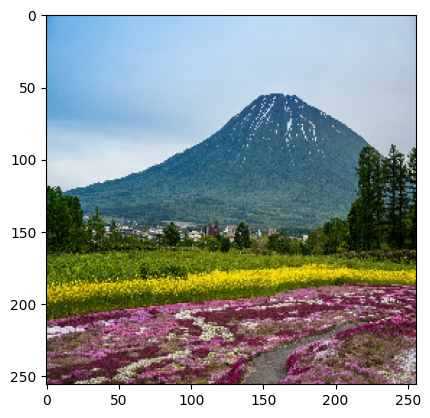

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5493669902431557..2.0496640442611094].


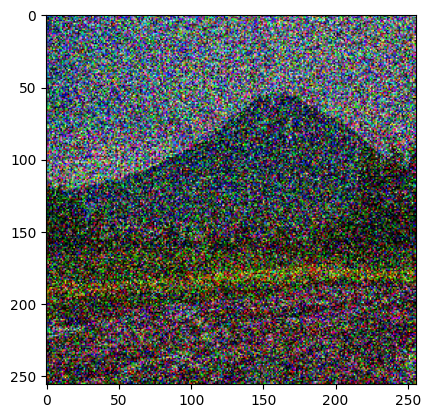

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.471656109504463..2.5878154534423534].


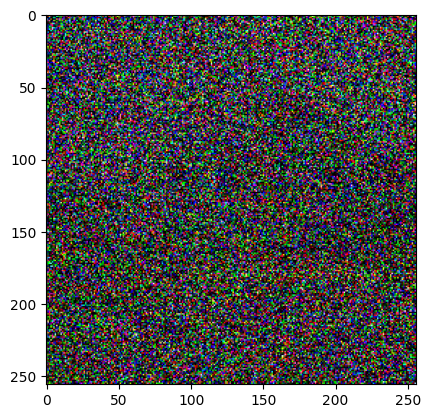

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.336160659790039..4.433101177215576].


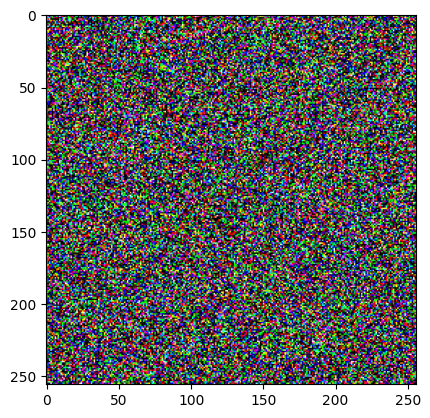

In [20]:
imshow(forward_chain[0])
imshow(forward_chain[3])
imshow(forward_chain[5])
imshow(forward_chain[-1])

```txt
t = 1: x(1) * im + y(1) * no = (1.0 * im + 0.0 * no) = a1 * im + b1 * no

t = 2: x(2) * im + y(2) * no = (0.9 * (1.0*im+0.0*no) + 0.1 * no)
    = a2 * (a1 * im + b1 * no) + b2 * no
    = a1 * a2 * im + a2 * b1 * no + b2 * no
    = (a1 * a2) * im + (a2 * b1 + b2) * no  # b = 1 - a
    = (a1 * a2) * im + (a2 * (1-a1) + (1-a2)) * no
    = (a1 * a2) * im + (a2 - (a1 * a2) + 1 - a2) * no
    = (a1 * a2) * im + (1 - (a1 * a2)) * no  # a_bar2 = a1 * a2
    = a_bar2 * im + (1 - a_bar2) * no

x(t) = a_bar(t)
y(t) = 1 - a_bar(t)

t = 3: x(3) * im + y(3) * no = (0.8 * (0.9*(1.0*im+0.0*no)+0.1*no) + 0.2 * no)
t = 4: x(4) * im + y(4) * no = (0.7 * (0.8*(0.9*(1.0*im+0.0*no)+0.1*no)+0.2*no) + 0.3 * no)
t = 5: x(5) * im + y(5) * no = (0.6 * (0.7*(0.8*(0.9*(1.0*im+0.0*no)+0.1*no)+0.2*no)+0.3*no) + 0.4 * no)
...
t = T: x(T) * im + y(T) * no =


---

t = 1: x(1) * im + y(1) * no + e(1) = (1.0 * im + 0.0 * no1) = a1 * im + b1 * no1
t = 2: a2 * (a1*im + b1*no1) + b2 * no2
    = a1 * a2 * im + b1 * a2 * no1 + b2 * no2  # b = 1 - a
    = (a1 * a2) * im + (1 - a1) * a2 * no1 + (1 - a2) * no2
    = a_bar2 * im + (1  - a2) * no2 + (a2 - a1 * a2) * no1
    = a_bar2 * im + (1  - a2) * no2 + (a2 - a_bar2) * no1

---


x(t) = a * x(t-1) + b * no
a * x(t-1) = x(t) - b * no
x(t-1) = 1/a * (x(t) - b * no)


forward(im, t) -> a_bar(t) * im

```

In [21]:
# Use the single step trick.
t = 1
assert 1 <= t <= T-2

noise1 = np.random.randn(*image.shape).astype(np.float32)
noise2 = np.random.randn(*image.shape).astype(np.float32)
# target_image = a_bar[t] / a[t] * image + (1 - a_bar[t] / a[t]) * noise1
target_image = a_bar[t-1] * image + (1 - a_bar[t-1]) * noise1
input_image = a[t] * target_image + b[t] * noise2

prediction = noise2
predicted_image = 1/a[t] * (input_image - b[t] * prediction)

print(np.mean((target_image - predicted_image) ** 2))
if t == 1:
    print(np.mean((target_image - image) ** 2))

1.4947654506091258e-33
1.3255911723452894e-08
